# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [42]:
# numerics
import jax
import jax.numpy as jnp
import numpy as np
import optax

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt

# fluids
from jf1uids.boundaries import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids.geometry import SPHERICAL
from jf1uids.physics_modules.stellar_wind import WindParams
from jf1uids.postprocessing import shock_sensor, strongest_shock_radius
from jf1uids.simulation_config import SimulationConfig
from jf1uids.simulation_helper_data import get_helper_data
from jf1uids.simulation_params import SimulationParams
from jf1uids.time_integration import time_integration
from jf1uids.fluid import primitive_state

# units
from jf1uids.unit_helpers import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from weaver import Weaver
from jax import grad

# # for now using CPU as of outdated NVIDIA Driver
jax.config.update('jax_platform_name', 'cpu')

# track nan
jax.config.update("jax_debug_nans", True)

# # 64-bit precision
jax.config.update("jax_enable_x64", True)

## Initiating the stellar wind simulation

In [43]:
from jf1uids.geometry import CARTESIAN


print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = CARTESIAN
box_size = 1.0
num_cells = 100
dx = box_size / num_cells

fixed_timestep = False

checkpointing = True
num_checkpoints = 40

# introduce constants to 
# make this more readable
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = False

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    checkpointing = checkpointing,
    num_checkpoints = num_checkpoints
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [44]:

# time domain
dt_max = 0.0001
C_CFL = 0.8
t_end = 0.2

# SOD shock tube
shock_pos = 0.5

r = helper_data.geometric_centers

rho = jnp.where(r < shock_pos, 1.0, 0.125)
u = jnp.zeros_like(r)
p = jnp.where(r < shock_pos, 1.0, 0.1)

# get initial state
initial_state = primitive_state(rho, u, p)

params = SimulationParams(C_cfl = C_CFL, dt_max = dt_max, dx = dx, gamma = gamma, t_end = t_end)

## Conservation test of the simulation

In [45]:
from jf1uids.fluid import calculate_total_energy_proxy, calculate_total_mass_proxy


def init_shock_problem(num_cells, config, params):
    dx = box_size / num_cells
    config = config._replace(num_cells = num_cells)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    rho = jnp.where(r < shock_pos, 1.0, 0.125)
    u = jnp.zeros_like(r)
    p = jnp.where(r < shock_pos, 1.0, 0.1)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

def init_acoustics_problem(num_cells, config, params):
    dx = box_size / num_cells
    config = config._replace(num_cells = num_cells)
    params = params._replace(dt_max = dt_max, dx = dx)
    helper_data = get_helper_data(config)
    r = helper_data.geometric_centers
    
    # # f = sin^4(pi * r) / r # where 0.4 <= r <= 0.6
    # f = jnp.where((r >= 0.4) & (r <= 0.6), jnp.sin(jnp.pi * ((r - 0.4) / 0.2))**4, 0.0)
    # # f = jnp.sin(jnp.pi * r)**4 / r
    # plt.plot(r, f)
    # epsilon = 1e-4
    rho = 1.5 * jnp.exp(-((r - 0.3) / 0.4)**2) + 1.0 * (1 - jnp.exp(-((r - 0.3) / 0.4)**2))
    u = jnp.ones_like(r)
    p = jnp.zeros_like(r)

    # get initial state
    initial_state = primitive_state(rho, u, p)
    return initial_state, config, params, helper_data

initial_state_shock, config_shock, params_shock, helper_data_shock = init_shock_problem(800, config, params)
checkpoints_shock = time_integration(initial_state_shock, config_shock, params_shock, helper_data_shock)


### Visualization of the mass and energy development

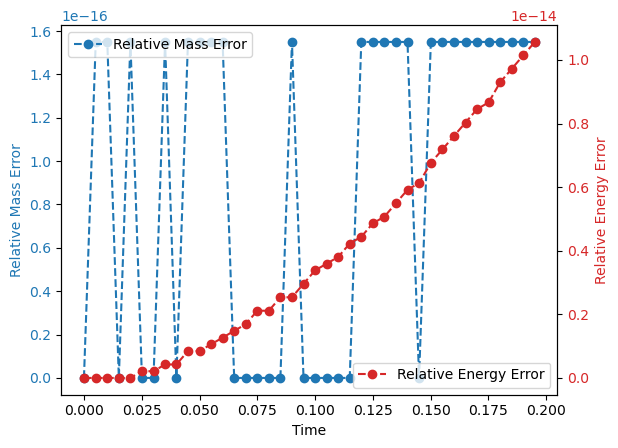

In [46]:
# plot checkpoints_shock.total_mass_proxy and checkpoints_shock.total_energy_proxy over time
relative_mass_error = jnp.abs(checkpoints_shock.total_mass_proxy - checkpoints_shock.total_mass_proxy[0]) / checkpoints_shock.total_mass_proxy[0]
relative_energy_error = jnp.abs(checkpoints_shock.total_energy_proxy - checkpoints_shock.total_energy_proxy[0]) / checkpoints_shock.total_energy_proxy[0]

fig, ax = plt.subplots()
color = 'tab:blue'
ax.plot(checkpoints_shock.times, relative_mass_error, "o--", label="Relative Mass Error", color=color)
ax.set_xlabel("Time")
ax.set_ylabel("Relative Mass Error", color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.legend(loc = "upper left")

# twin x for energy
color = 'tab:red'
ax2 = ax.twinx()
ax2.plot(checkpoints_shock.times, relative_energy_error, "o--", label="Relative Energy Error", color=color)
ax2.set_ylabel("Relative Energy Error", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = "lower right")


In [47]:
# resolutions_to_test = [641, 1281, 2561, 5121, 10241]

# L1_errors = jnp.zeros(len(resolutions_to_test))

# for idx, num_cells in enumerate(resolutions_to_test):

#     print(f"Testing resolution {num_cells}...")

#     initial_state_test, config_test, params_test, helper_data_test = init_acoustics_problem(num_cells, config, params)
#     final_state_test = time_integration(initial_state_test, config_test, params_test, helper_data_test)
    
#     if alpha == 0:
#         r_test = helper_data_test.geometric_centers
#     else:
#         r_test = helper_data_test.volumetric_centers

#     # Find the indices of the closest points in the high-resolution grid (r_best)
#     indices = jnp.searchsorted(r_best, r_test)

#     # Handle edge cases where searchsorted can give an index out of bounds
#     indices = jnp.clip(indices, 0, len(r_best) - 1)

#     # Compute the L1 error comparing low-res values to closest high-res values
#     L1_error = jnp.sqrt((jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2 + (jnp.mean(jnp.abs(final_state_test[0] - final_state_best[0, indices]))) ** 2)

#     L1_errors = L1_errors.at[idx].set(L1_error)

# print(L1_errors)

In [48]:
# resolutions_to_test = jnp.array(resolutions_to_test, dtype=jnp.float64)

# plt.loglog(resolutions_to_test, L1_errors, marker='o')

# # fit a line to the log-log data, to estimate the convergence rate
# m, b = np.polyfit(np.log(resolutions_to_test), np.log(L1_errors), 1)
# plt.loglog(resolutions_to_test, np.exp(m * np.log(resolutions_to_test) + b), linestyle='--', label=f"Convergence rate: {m:.2f}")

# plt.xlabel("Number of cells")
# plt.ylabel("L1 error")
# # plt.title("Convergence of Sod shock tube problem")
# plt.legend()

## Visualization

Text(0.5, 1.0, 'Pressure')

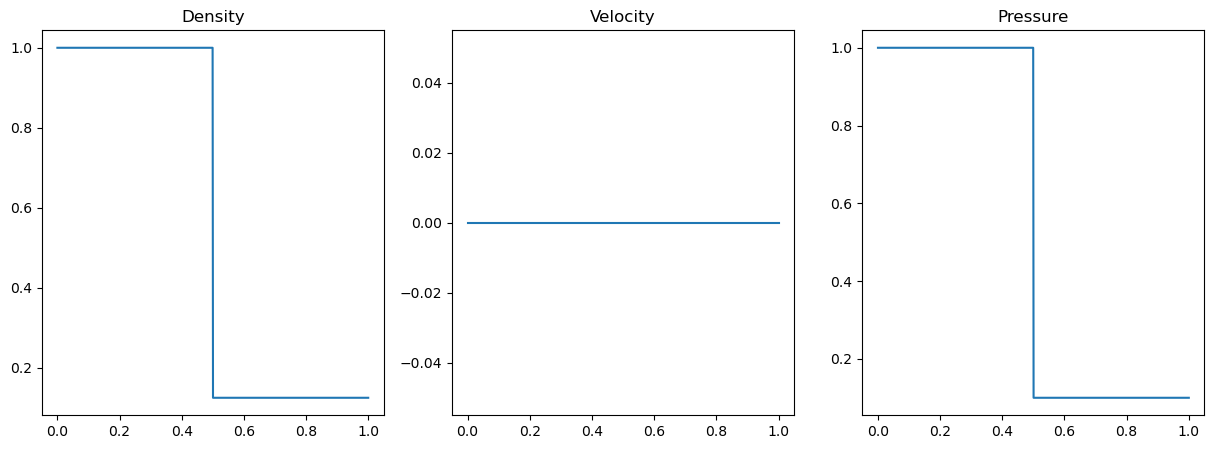

In [49]:
# # initial_state, config, params, helper_data = init_acoustics_problem(100, config, params)

# # final_state = time_integration(initial_state, config, params, helper_data)

rho, u, p = checkpoints_shock.states[0]
r = helper_data_shock.geometric_centers

## plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho)
axs[0].set_title("Density")

axs[1].plot(r, u)
axs[1].set_title("Velocity")

axs[2].plot(r, p)
axs[2].set_title("Pressure")